## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pydlm import dlm, trend, seasonality, dynamic, autoReg
from pathlib import Path
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use("ggplot")

## Data

In [2]:
PATH_DATA = Path("../Data")

In [3]:
df = pd.read_csv(PATH_DATA / "h2weekly.csv", parse_dates=["Date"])

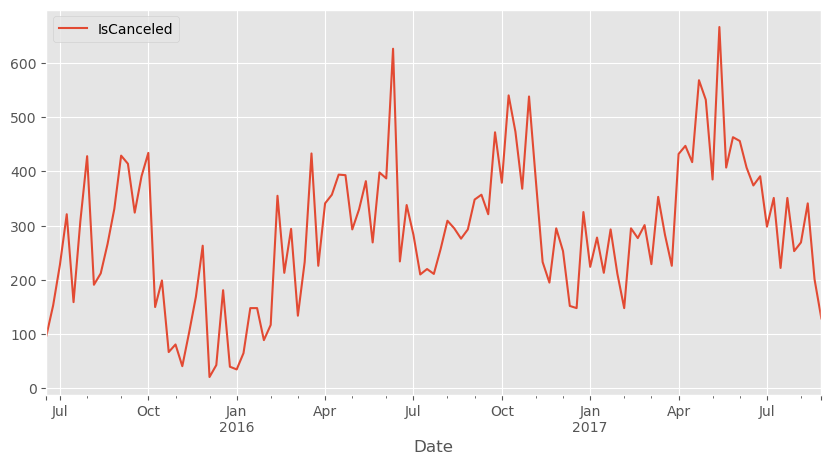

In [4]:
df.plot(x="Date", y="IsCanceled", figsize=(10, 5));

## Simple Model

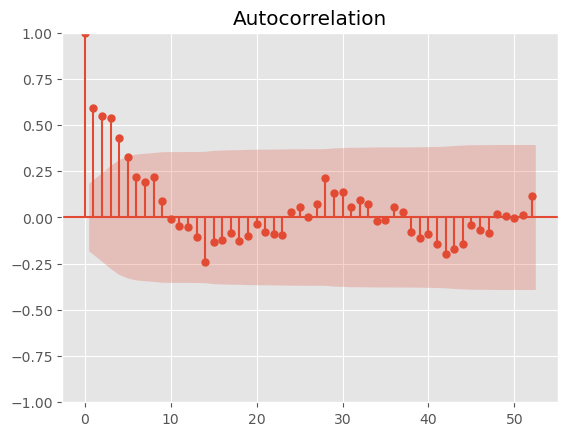

In [5]:
# ACF
plot_acf(df["IsCanceled"], lags=52);

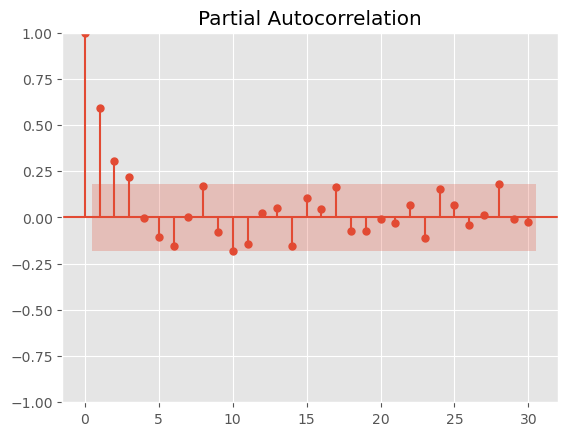

In [6]:
# PACF
plot_pacf(df["IsCanceled"], lags=30);

In [7]:
# Linear trend
linear_trend = trend(degree=1, discount=0.9, name="linear_trend", w=10.0)
# Seasonality
seasonal = seasonality(period=28, discount=0.9, name="seasonal", w=10.0)

# Build a simple dlm
simple_dlm = dlm(df["IsCanceled"]) + linear_trend + seasonal

In [8]:
# Fit the model
simple_dlm.fit()


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


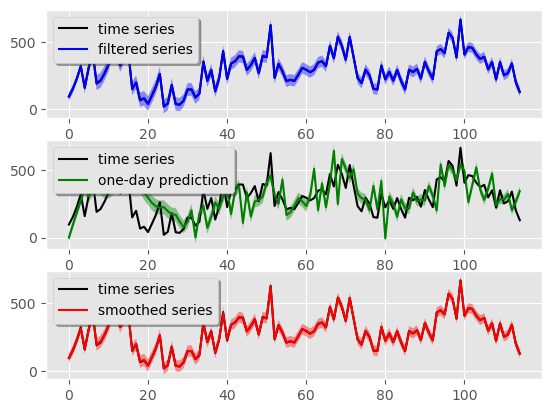

In [9]:
simple_dlm.turnOff('data points')
simple_dlm.plot()

In [10]:
np.sqrt(simple_dlm.getMSE())

124.2989302544749

In [11]:
from pydlm import modelTuner
myTuner = modelTuner(method='gradient_descent', loss='mse')
tunedDLM = myTuner.tune(simple_dlm, maxit=100)

INFO:pydlm:Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
INFO:pydlm:Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.


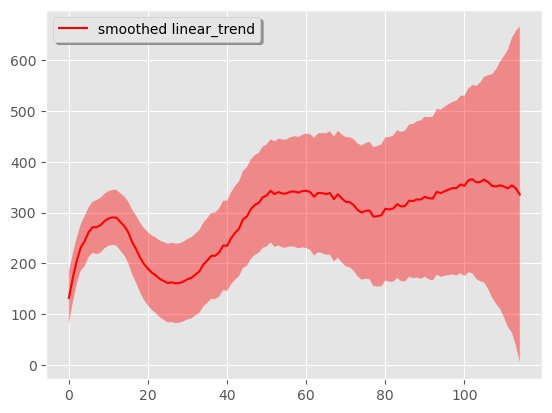

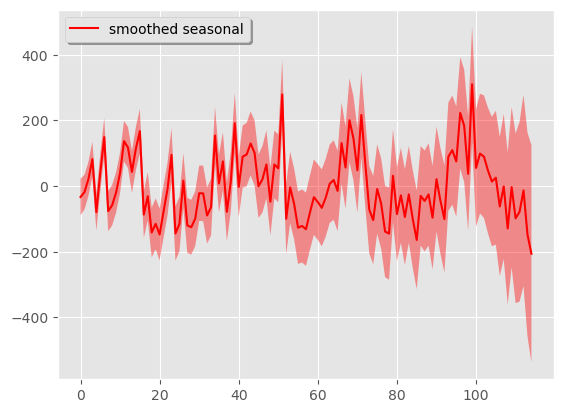

In [12]:
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal')

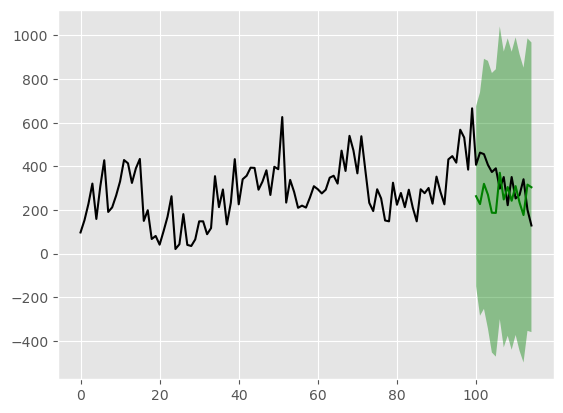

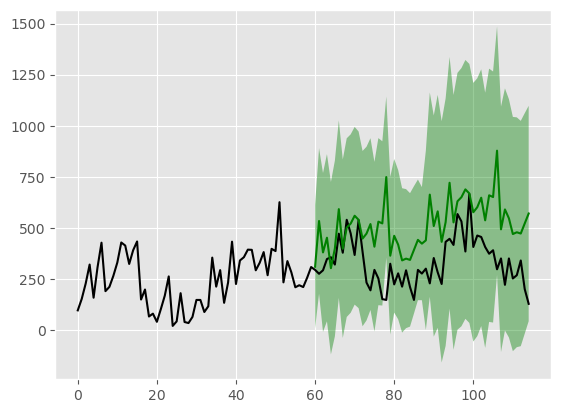

In [13]:
# Plotted prediction for the first 100 weeks, with a forecast generated for the following 15 weeks.
simple_dlm.plotPredictN(date=100, N=15)
# Plotted prediction for the first 60 weeks, with a forecast generated for the following 55 weeks.
simple_dlm.plotPredictN(date=60, N=55)

In [14]:
a = simple_dlm.predictN(date=100, N=15)
a

([263.2174962910017,
  226.99837656092728,
  319.9539037850848,
  270.1468200258449,
  187.37469262201935,
  186.53409484376323,
  370.6263122038413,
  248.2771301074626,
  305.19903000508066,
  242.3810616601848,
  309.41533964038723,
  234.0319785364295,
  176.68837424954958,
  316.3702752828107,
  304.2134372053696],
 [44345.135388330156,
  68118.6162449084,
  85438.46686257751,
  97923.84264849842,
  106782.96460722042,
  112922.96321926938,
  117019.77730790924,
  119571.58381202281,
  120940.98220592718,
  121388.43464278913,
  121098.90921404863,
  120202.82982850588,
  118801.83586542754,
  116953.68311898256,
  114699.75382909412])

In [15]:
a = np.array(a)
b = a[0]
b

array([263.21749629, 226.99837656, 319.95390379, 270.14682003,
       187.37469262, 186.53409484, 370.6263122 , 248.27713011,
       305.19903001, 242.38106166, 309.41533964, 234.03197854,
       176.68837425, 316.37027528, 304.21343721])

In [16]:
np.mean(df["IsCanceled"])

287.8434782608696

In [17]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [18]:
rmse(b, df["IsCanceled"].values[100:115])   

141.46927900577708

## Model 2

In [19]:
np_rng = np.random.default_rng(42)

additional_features = np_rng.normal(size=(len(df), 5))
additional_features.shape

(115, 5)

In [20]:
dynamic_dlm = dlm(df["IsCanceled"]) 
dynamic_dlm = dynamic_dlm + trend(1, name='lineTrend', w=1.0)
dynamic_dlm = dynamic_dlm + seasonality(28, name='seasonal28', w=1.0)
dynamic_dlm = dynamic_dlm + autoReg(degree=2, name='ar2', w=1.0)

ctrend = dynamic(features=additional_features, discount=0.9, name='random', w=1.0)
dynamic_dlm = dynamic_dlm + ctrend

dynamic_dlm.ls()

The static components are
lineTrend (degree = 2)
seasonal28 (degree = 28)
 
The dynamic components are
random (dimension = 5)
 
The automatic components are
ar2 (dimension = 2)


In [21]:
dynamic_dlm.fit()

INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


In [22]:
dynamic_dlm.fitForwardFilter()
dynamic_dlm.fitBackwardSmoother()

INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...


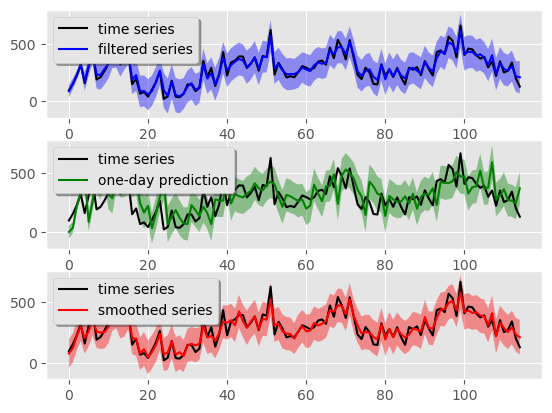

In [23]:
# Plot
dynamic_dlm.turnOff('data points')
dynamic_dlm.plot()

In [24]:
dynamic_dlm.turnOn("smoothed plot")
dynamic_dlm.turnOff("predict plot")

In [25]:
my_tuner = modelTuner(method='gradient_descent', loss='mse')
tuned_dlm = my_tuner.tune(dynamic_dlm, maxit=100)

INFO:pydlm:Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
INFO:pydlm:Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.


In [26]:
tuned_dlm.fit()

INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...


In [27]:
np.sqrt(tuned_dlm.getMSE())

120.43663403327274

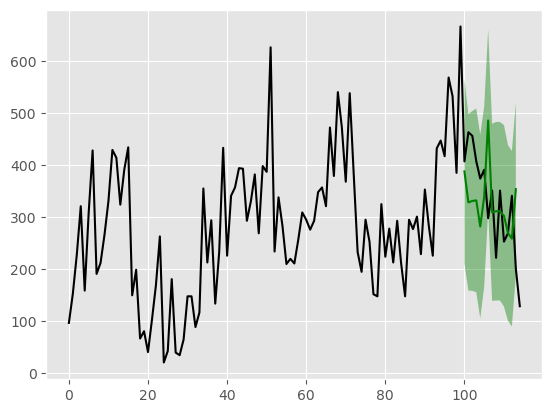

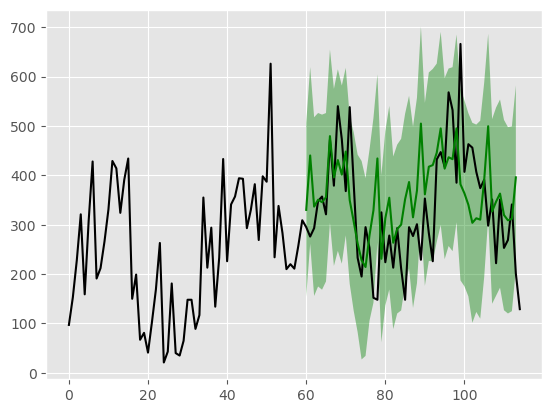

In [28]:
# Plotted prediction for the first 100 weeks, with a forecast generated for the following 14 weeks.
tuned_dlm.plotPredictN(date=100, N=14)
# Plotted prediction for the first 60 weeks, with a forecast generated for the following 54 weeks.
tuned_dlm.plotPredictN(date=60, N=54)

In [29]:
# Plotted prediction for the first 100 weeks, with a forecast generated for the following 14 weeks.
a = tuned_dlm.predictN(date=100, N=14)
a

([387.7541909538328,
  328.3249391846932,
  331.0732835101851,
  332.11766815506445,
  281.9610803133124,
  339.4661859577745,
  485.6369956977218,
  309.25470952802675,
  311.36771447343386,
  311.288074469962,
  302.430671251948,
  269.72091942880655,
  258.6441256121917,
  353.73981096052165],
 [8121.4455551154515,
  7453.986112738778,
  7755.736546727194,
  8091.578949612942,
  8095.838764795288,
  7779.6509358440735,
  7918.720566177888,
  7519.03088506132,
  7633.325182517335,
  7633.6801713457835,
  7894.030614446683,
  7388.458846948459,
  7377.4952356923895,
  7169.736115102156])

In [30]:
a = np.array(a)
b = a[0]
b

array([387.75419095, 328.32493918, 331.07328351, 332.11766816,
       281.96108031, 339.46618596, 485.6369957 , 309.25470953,
       311.36771447, 311.28807447, 302.43067125, 269.72091943,
       258.64412561, 353.73981096])

In [31]:
test = df["IsCanceled"].values[100:114]

In [32]:
rmse(b, test)

96.33220265162151

In [33]:
np.mean(test)

341.7142857142857